# This notebook contains the code for reproducing results for the following aims:


*   Aim 2: Neglect outcome random forest models
*   Aim 3: Socioeconomic and race association tests with different neglect dimensions



# Install

In [1]:
!pip install shap
# !pip install lime
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=03339ae69e5be7f6a18b9a43509aa34a25383dfe28d110a6d7061bbd05995e26
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


# Import Libraries



Import some libraries

In [2]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import io

Mounted at /content/drive


# Utilities

Thesea are mostly helper functions to do miscellaneous data wrangling more easily. Run this whole block, since some of the functions are used later

In [3]:
# missing values per column function
def show_missing_values(df):
    missing_counts = df.isnull().sum()
    missing_percentages = 100 * missing_counts / len(df)
    missing_table = pd.concat([missing_counts, missing_percentages], axis=1)
    missing_table = missing_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    missing_table = missing_table[missing_table.iloc[:, 0] != 0].sort_values('% of Total Values', ascending=False)
    return missing_table

In [4]:
def find_no_missing_cols(df):
    no_missing_cols = df.columns[df.isnull().sum() == 0]
    return no_missing_cols

In [5]:
def get_string_columns(df):
    string_cols = []
    for col in df.columns:
        if df[col].apply(lambda x: any([i.isalpha() for i in str(x)])).any():
            string_cols.append(col)
    return string_cols

In [6]:
def convert_sex_to_binary(df, column_name):
    # create a new column with binary values
    df['binary_sex'] = df[column_name].apply(lambda x: 1 if x == 'M' else 0)
    return df

def convert_binary_to_sex(df, column_name):
    # create a new column with 'M' or 'F' values
    df['sex_from_binary'] = df[column_name].apply(lambda x: 'M' if x == 1 else 'F')
    return df

In [7]:
# get rid of nan and all that undefined behavior
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=False)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(float)

In [8]:
def select_all_except_first_row(df):
    return df.iloc[1:]

In [9]:
# missing values per row
def count_nan_rows(df):
    total_rows = len(df)
    nan_rows = df.isnull().any(axis=1).sum()
    nan_percent = 100 * (nan_rows / total_rows)
    print("Number of rows with NaN values: {}".format(nan_rows))
    print("Percentage of rows with NaN values: {:.2f}%".format(nan_percent))
    return nan_rows, nan_percent

In [10]:
def show_missing_rows(df):
    missing_counts = df.isnull().sum(axis=1)
    missing_percentages = 100 * missing_counts / len(df.columns)
    missing_table = pd.concat([missing_counts, missing_percentages], axis=1)
    missing_table = missing_table.rename(columns={0: 'Missing Values', 1: '% of Total Columns'})
    missing_table = missing_table[missing_table.iloc[:, 0] != 0].sort_values('% of Total Columns', ascending=False)
    return missing_table

In [11]:
def count_value(df, value):
    count = (df == value).sum()
    count_table = pd.DataFrame({'Column': count.index, 'Count': count.values}).sort_values('Count', ascending=False)
    return count_table

In [12]:
def remove_rows_with_value(df, value):
    new_df = df[~(df == value).any(axis=1)]
    return new_df

In [13]:
def get_value_counts(df):
  # get unique values and counts for each column
  for column in df.columns:
      counts = df[column].value_counts()
      print(f"Counts for column '{column}':\n{counts}\n")

In [14]:
def compute_stats_ed(df, col1, col2, col3):
    df['Avg Ed'] = df.apply(lambda x: (x[col1] + x[col2])/2 if x[col3] == 1 else x[col1], axis=1)
    df['Max Ed'] = df.apply(lambda x: max(x[col1], x[col2]) if x[col3] == 1 else x[col1], axis=1)
    df['Sum Ed'] = df.apply(lambda x: x[col1] if x[col3] != 1 else x[col1] + x[col2], axis=1)
    return df

In [15]:
def check_number_in_columns(df, columns, number):
    for col in columns:
        if number in df[col].values:
            return True
    return False

In [16]:
def sum_columns(df, column_list, new_column_name):
    df[new_column_name] = df[column_list].sum(axis=1)
    return df

In [17]:
def distplots(df, bins=100):
  for i in range(1,len(df.columns)) :
      col_name = df.columns[i]  # get the column name to identify the graph
      x=df[col_name]
      plt.xlabel(col_name)         # The column name will be the x-label ( just to identify )
      k=plt.hist(x,bins)       # Change the right number of bins to get it more/less granular
      plt.show()

In [18]:
def select_columns(df, condition_col, condition_func, cols_to_select):
    """
    Selects a list of columns from a Pandas dataframe based on whether a condition is satisfied in one of the columns.
    """
    # Filter the dataframe to only include rows where the condition is satisfied
    filtered_df = df[df[condition_col].apply(condition_func)]

    # Select the desired columns from the filtered dataframe
    selected_df = filtered_df[cols_to_select]

    return selected_df

In [19]:
def check_value(df, value_cols, no_value_cols, value, new_col_name):
    # Check if value is present only in the specified value_cols
    mask_value = (df[value_cols] == value).all(axis=1)

    # Check if value is not present in any of the specified no_value_cols
    mask_no_value = (df[no_value_cols] != value).all(axis=1)

    # Create a new column with a 1 if both conditions are met, 0 otherwise
    df[new_col_name] = 0
    df.loc[mask_value & mask_no_value, new_col_name] = 1

    return df

In [20]:
def convert_str_to_num(df):
    """
    Converts string representations of numbers in a dataframe to float data type.
    """
    for col in df.columns:
        if df[col].dtypes == object:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # if the column can't be converted, ignore it
    return df

In [21]:
def convert_columns_to_float(df):
    """
    Converts all columns of a Pandas dataframe to be of type float, except for ones that contain alphabetic characters.
    """
    # Get a boolean mask indicating which columns contain alphabetic characters
    non_numeric_cols = df.select_dtypes(include=['object']).apply(lambda col: pd.to_numeric(col, errors='coerce').isna()).any()

    # Select only the numeric columns
    numeric_cols = df.select_dtypes(include=['float', 'int'])

    # Convert the numeric columns to float
    numeric_cols = numeric_cols.apply(pd.to_numeric, errors='coerce').astype('float')

    # Merge the numeric and non-numeric columns
    converted_df = pd.concat([numeric_cols, df.loc[:, non_numeric_cols]], axis=1)

    return converted_df

In [22]:
def column_description_dict(df):
    # Get the first row of the dataframe
    first_row = df.iloc[0]

    # Create a dictionary with column names as keys and first row values as descriptions
    column_descriptions = {col: first_row[col] for col in df.columns}

    return column_descriptions

In [23]:
def my_recode(x):
    if x == 1:
        return 1
    else:
        return 0

# Load dataframe

Raw csv from github is downloaded into a pandas dataframe

In [24]:
# Downloading the csv file from GitHub
url = "https://raw.githubusercontent.com/joshbenjamin3/251/main/Neglect%20outcomes.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

In [25]:
aim1_df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [27]:
aim1_df = aim1_df.drop('Unnamed: 0', axis=1)

In [ ]:
aim1_df

# Model ready dataframe

DataFrame is convereted to numpy array format for being input into models

## Aim 2 and 3

In [29]:
X_1 = aim1_df[['Household Size', 'Partner Status', 'Max Ed', 'INR',
       'Employment Status', 'ADI', 'COI',
       'Race grouping', 'Sex', 'Age', 'Parent psychopathology', 'Abuse']]

X_1_og = aim1_df[['Household Size', 'Partner Status', 'Max Ed', 'INR',
       'Employment Status', 'ADI', 'COI',
       'Race grouping', 'Sex', 'Age', 'Adult Psychopathology', 'Abuse']]

y_p = aim1_df[['Physical neglect']]

y_e = aim1_df[['Emotional neglect']]

y_s = aim1_df[['Supervisory neglect']]

In [30]:
convert_sex_to_binary(X_1, 'Sex')

<ipython-input-6-3de380f54f7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binary_sex'] = df[column_name].apply(lambda x: 1 if x == 'M' else 0)


,Household Size,Partner Status,Max Ed,INR,Employment Status,ADI,COI,Race grouping,Sex,Age,Parent psychopathology,Abuse,binary_sex
0,12.0,1,18.0,2.584425,0,27.0,77.0,white,M,10.0,0,0,1
1,3.0,0,14.0,0.122429,0,51.0,30.0,black,M,9.0,0,0,1
2,4.0,1,20.0,8.130081,1,45.0,98.0,white,M,9.0,0,0,1
3,4.0,1,19.0,6.097561,1,24.0,87.0,white,F,9.0,0,0,0
4,5.0,1,19.0,3.040306,2,48.0,45.0,white,F,10.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,3.0,0,19.0,3.060725,1,24.0,87.0,other,F,10.0,0,0,0
9491,4.0,0,16.0,1.727642,2,100.0,1.0,black,M,10.0,0,0,1
9492,4.0,1,15.0,0.386179,1,98.0,7.0,other,F,10.0,0,0,0
9493,4.0,1,12.0,0.386179,2,40.0,32.0,hispanic,M,9.0,1,0,1


In [31]:
X_1 = X_1.drop('Sex', axis=1)

In [32]:
# Convert "Race grouping" column into one-hot vectors
one_hot_df = pd.get_dummies(X_1['Race grouping'], prefix='', prefix_sep='')

# Concatenate the original DataFrame and the one-hot vectors
X_1 = pd.concat([X_1, one_hot_df], axis=1)

In [33]:
aim1_0_df = pd.concat([aim1_df, one_hot_df], axis=1)

In [34]:
X_1 = X_1.drop('Race grouping', axis=1)

In [35]:
show_missing_values(X_1)

,Missing Values,% of Total Values


In [36]:
X_1

,Household Size,Partner Status,Max Ed,INR,Employment Status,ADI,COI,Age,Parent psychopathology,Abuse,binary_sex,black,hispanic,other,white
0,12.0,1,18.0,2.584425,0,27.0,77.0,10.0,0,0,1,0,0,0,1
1,3.0,0,14.0,0.122429,0,51.0,30.0,9.0,0,0,1,1,0,0,0
2,4.0,1,20.0,8.130081,1,45.0,98.0,9.0,0,0,1,0,0,0,1
3,4.0,1,19.0,6.097561,1,24.0,87.0,9.0,0,0,0,0,0,0,1
4,5.0,1,19.0,3.040306,2,48.0,45.0,10.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,3.0,0,19.0,3.060725,1,24.0,87.0,10.0,0,0,0,0,0,1,0
9491,4.0,0,16.0,1.727642,2,100.0,1.0,10.0,0,0,1,1,0,0,0
9492,4.0,1,15.0,0.386179,1,98.0,7.0,10.0,0,0,0,0,0,1,0
9493,4.0,1,12.0,0.386179,2,40.0,32.0,9.0,1,0,1,0,1,0,0


In [37]:
X_1.reset_index(drop=True, inplace=True)
y_p.reset_index(drop=True, inplace=True)
y_e.reset_index(drop=True, inplace=True)
y_s.reset_index(drop=True, inplace=True)

In [38]:
X_1.columns

Index(['Household Size', 'Partner Status', 'Max Ed', 'INR',
       'Employment Status', 'ADI', 'COI', 'Age', 'Parent psychopathology',
       'Abuse', 'binary_sex', 'black', 'hispanic', 'other', 'white'],
      dtype='object')

# Random forest models

## ML model and analysis dependencies

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

In [40]:
import shap
import eli5
from eli5.sklearn import PermutationImportance

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [41]:
import itertools

## Model functions

In [45]:
def run_single_model(X, y, cv, scoring):
    # Create a pipeline
    pipe = Pipeline([('preprocessing', StandardScaler()),
                     ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))])

    scores = []
    for _ in range(cv.get_n_splits(X, y)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        score = {metric: score_func(y_test, y_pred) for metric, score_func in scoring.items()}
        scores.append(score)

        model = pipe.named_steps['classifier']

    return scores, pipe, model


# Scoring dictionary
scoring = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'auc': lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='weighted'),
    'confusion_matrix': lambda y_true, y_pred: confusion_matrix(y_true, y_pred),
    'roc_curve': lambda y_true, y_pred: roc_curve(y_true, y_pred),
    'precision_recall_curve': lambda y_true, y_pred: precision_recall_curve(y_true, y_pred)
}

In [46]:
# Create an instance of StratifiedKFold
strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [47]:
def extract_instances(dataset, num_instances):
    # Check if the number of instances requested is greater than the dataset size
    if num_instances > len(dataset):
        raise ValueError("Number of instances requested is greater than dataset size.")

    # Resample the dataset to extract the desired number of instances
    extracted_instances = resample(dataset, n_samples=num_instances, replace=False)

    return extracted_instances

In [48]:
def calculate_permutation_importance(model, X, y, scoring_metric):
    perm_importance = PermutationImportance(model, scoring=scoring_metric, random_state=42)
    perm_importance.fit(X, y)
    feature_importances = perm_importance.feature_importances_
    feature_names = X.columns

    sorted_indices = np.argsort(feature_importances)
    sorted_importances = feature_importances[sorted_indices][::-1]
    sorted_names = feature_names[sorted_indices][::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_names)
    plt.xlabel('Permutation Importance')
    plt.ylabel('Features')
    plt.title('Permutation Importance of Features')
    plt.show()

## Plotting functions

In [43]:
def plot_evaluation(pipe, X, y):
    # Calculate and display evaluation metrics
    y_pred = pipe.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Confusion Matrix
    im = axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('True')
    axes[0, 0].set_title('Confusion Matrix')

    # Add numbers to the confusion matrix cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0, 0].text(j, i, cm[i, j], ha='center', va='center', color='black')

    # Colorbar for the confusion matrix
    cbar = axes[0, 0].figure.colorbar(im, ax=axes[0, 0])
    cbar.ax.set_ylabel('Counts', rotation=90, va='bottom')

    # ROC Curve
    axes[0, 1].plot(fpr, tpr)
    axes[0, 1].plot([0, 1], [0, 1], 'k--')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')

    # Precision-Recall Curve
    axes[1, 0].plot(recall, precision)
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')

    # Feature Importances
    importances = pipe.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]  # Reverse order

    axes[1, 1].barh(range(len(indices)), importances[indices], color='b', align='center')
    axes[1, 1].set_yticks(range(len(indices)))
    axes[1, 1].set_yticklabels([X.columns[i] for i in indices])
    axes[1, 1].set_xlabel('Relative Importance')
    axes[1, 1].set_title('Feature Importances')
    axes[1, 1].invert_yaxis()

    # # Display evaluation metrics
    # table_data = [['Accuracy', accuracy],
    #               ['Precision', precision],
    #               ['Recall', recall],
    #               ['F1-Score', f1],
    #               ['AUC', auc]]

    # # Select the top value for each metric
    # table_data = [[metric, score] for metric, score in table_data]

    # table = axes[1, 0].table(cellText=table_data, colWidths=[0.3, 0.2], loc='center')
    # table.auto_set_font_size(False)
    # table.set_fontsize(10)

    # Adjust plot layout
    plt.tight_layout()
    plt.show()

In [44]:
def generate_metrics_table(scores):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metrics_table = pd.DataFrame(columns=['Metric', 'Score'])

    for metric in metrics:
        scores_for_metric = [score[metric] for score in scores]
        max_score = np.max(scores_for_metric)

        metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)

    return metrics_table

## Association tests (aim 3)

This contains the functions and computations of the $\chi^2$ analyis

In [ ]:
def create_contingency_table(df, variable1, variable2):
    # Select the columns of interest from the DataFrame
    subset = df[[variable1, variable2]]

    # Create the contingency table using pandas crosstab
    contingency_table = pd.crosstab(subset[variable1], subset[variable2])

    return contingency_table

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
def calculate_chi2_test(df, variable1, variable2):
    # Create the contingency table using pandas crosstab
    contingency_table = pd.crosstab(df[variable1], df[variable2])

    # Perform G-test
    g, p, _, expected = chi2_contingency(contingency_table)

    # lambda_="log-likelihood"
    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Chi2 test statistic': [g],
        'p-value': [p]
    })

    return results_df

### Race and neglect type

In [ ]:
aim1_df[["INR Group"]]

,INR Group
0,mid income
1,deep poverty
2,high income
3,high income
4,mid income
...,...
9490,mid income
9491,near poverty
9492,deep poverty
9493,deep poverty


In [ ]:
get_value_counts(aim1_df[['Race']])

Counts for column 'Race':
White                                           5282
Black                                           1214
White/Hispanic                                  1014
Other Race/Hispanic                              315
White/Black                                      282
                                                ... 
Japanese/Other Race                                1
White/American Indian/Alaska Native/Hispanic       1
White/Asian Indian/Hispanic                        1
White/Black/American Indian/Korean                 1
White/Chinese/Other Asian                          1
Name: Race, Length: 172, dtype: int64



In [ ]:
pd.crosstab(aim1_df['Race grouping'], aim1_df['Physical neglect'])

Physical neglect,0,1
Race grouping,,
black,852,362
hispanic,1387,400
other,1011,201
white,4800,482


In [ ]:
pd.crosstab(aim1_df['Race grouping'], aim1_df['Emotional neglect'])

Emotional neglect,0,1
Race grouping,,
black,1175,39
hispanic,1757,30
other,1188,24
white,5193,89


In [ ]:
pd.crosstab(aim1_df['Race grouping'], aim1_df['Supervisory neglect'])

Supervisory neglect,0,1
Race grouping,,
black,1134,80
hispanic,1698,89
other,1152,60
white,5105,177


In [ ]:
pd.crosstab(aim1_df['Race grouping'], aim1_df['INR Group'])

INR Group,deep poverty,high income,mid income,near poverty,poverty
Race grouping,,,,,
black,321,152,247,307,187
hispanic,231,420,485,390,261
other,101,593,252,197,69
white,107,3033,1415,561,166


In [ ]:
pd.crosstab(aim1_df['Physical neglect'], aim1_df['INR Group'])

INR Group,deep poverty,high income,mid income,near poverty,poverty
Physical neglect,,,,,
0,439,4105,2073,1024,409
1,321,93,326,431,274


In [ ]:
pd.crosstab(aim1_0_df['Physical neglect'], aim1_0_df['white'])

white,0,1
Physical neglect,,
0,3250,4800
1,963,482


In [ ]:
pd.crosstab(aim1_0_df['Physical neglect'], aim1_0_df['black'])

black,0,1
Physical neglect,,
0,7198,852
1,1083,362


In [ ]:
calculate_chi2_test(aim1_df, 'INR Group', 'Physical neglect')

,Chi2 test statistic,p-value
0,1547.177464,0.0


In [ ]:
calculate_chi2_test(aim1_df, 'Race grouping', 'Physical neglect')

,Chi2 test statistic,p-value
0,425.420967,6.892513e-92


In [ ]:
calculate_chi2_test(aim1_df, 'Race grouping', 'Emotional neglect')

,Chi2 test statistic,p-value
0,12.915371,0.004823


In [ ]:
calculate_chi2_test(aim1_df, 'Race grouping', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,30.433555,0.000001


In [ ]:
calculate_chi2_test(aim1_df, 'Race grouping', 'INR Group')

,Chi2 test statistic,p-value
0,2077.314078,0.0


In [ ]:
calculate_chi2_test(aim1_0_df, 'black', 'Physical neglect')

,Chi2 test statistic,p-value
0,228.677625,1.158068e-51


In [ ]:
calculate_chi2_test(aim1_0_df, 'white', 'Physical neglect')

,Chi2 test statistic,p-value
0,341.4831,3.033052e-76


In [ ]:
calculate_chi2_test(aim1_0_df, 'hispanic', 'Physical neglect')

,Chi2 test statistic,p-value
0,86.912084,1.134540e-20


In [ ]:
calculate_chi2_test(aim1_0_df, 'other', 'Physical neglect')

,Chi2 test statistic,p-value
0,1.888659,0.169353


In [ ]:
calculate_chi2_test(aim1_0_df, 'black', 'Emotional neglect')

,Chi2 test statistic,p-value
0,11.652689,0.000641


In [ ]:
calculate_chi2_test(aim1_0_df, 'white', 'Emotional neglect')

,Chi2 test statistic,p-value
0,3.130843,0.076824


In [ ]:
calculate_chi2_test(aim1_0_df, 'hispanic', 'Emotional neglect')

,Chi2 test statistic,p-value
0,0.516485,0.472345


In [ ]:
calculate_chi2_test(aim1_0_df, 'other', 'Emotional neglect')

,Chi2 test statistic,p-value
0,0.003624,0.951995


In [ ]:
calculate_chi2_test(aim1_0_df, 'black', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,17.565055,0.000028


In [ ]:
calculate_chi2_test(aim1_0_df, 'white', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,24.374368,7.931702e-07


In [ ]:
calculate_chi2_test(aim1_0_df, 'hispanic', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,2.461278,0.116684


In [ ]:
calculate_chi2_test(aim1_0_df, 'other', 'Supervisory neglect')

,Chi2 test statistic,p-value
0,1.361398,0.243295


## Neglect outcomes (aim 2)

Models grouped by outcome along with scoring metrics, and feature importances

### Physical Neglect

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

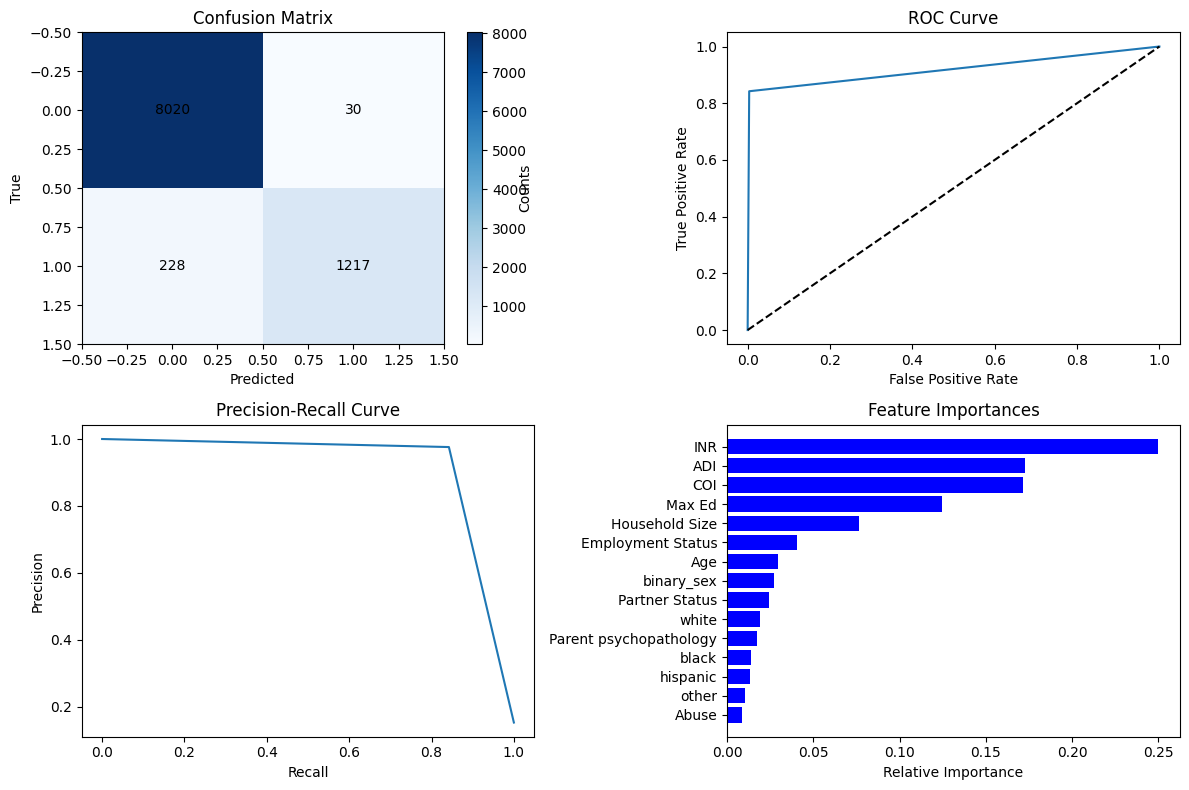

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.865192
1,Precision,0.845325
2,Recall,0.865192
3,F1,0.833471
4,Auc,0.596841


In [49]:
# Run single model
scores_p, pipe_p, model_p = run_single_model(X_1, y_p, strat_k_fold, scoring)

plot_evaluation(pipe_p, X_1, y_p)

generate_metrics_table(scores_p)

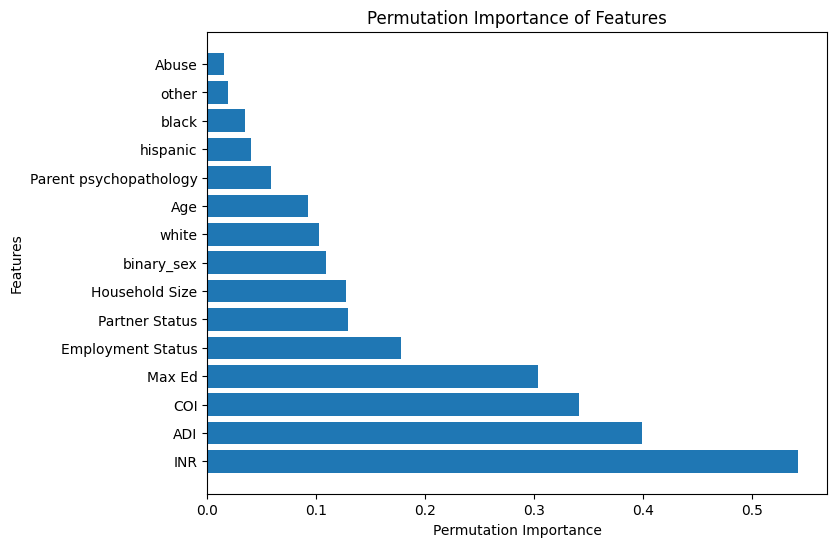

In [55]:
calculate_permutation_importance(pipe_p, X_1, y_p, 'f1')

### Emotional Neglect

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

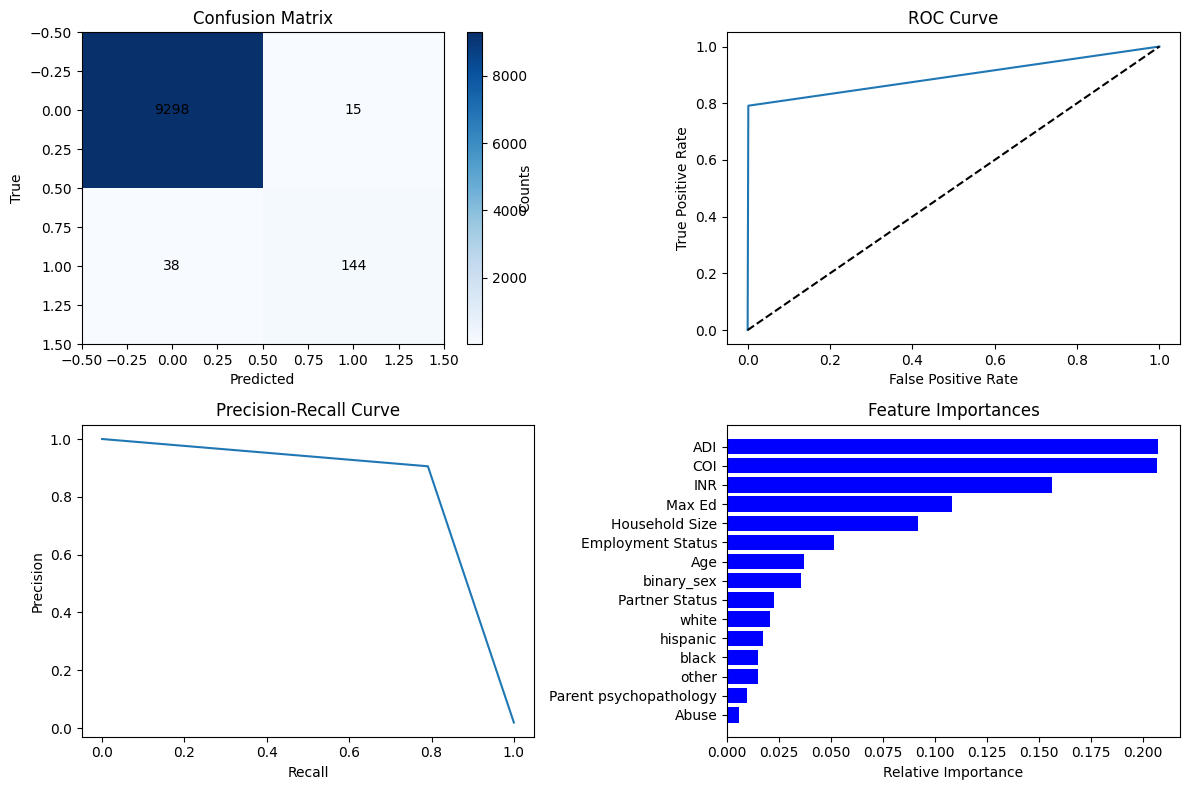

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.979989
1,Precision,0.962425
2,Recall,0.979989
3,F1,0.971128
4,Auc,0.499463


In [51]:
# Run single model
scores_e, pipe_e, model_e = run_single_model(X_1, y_e, strat_k_fold, scoring)

plot_evaluation(pipe_e, X_1, y_e)

generate_metrics_table(scores_e)

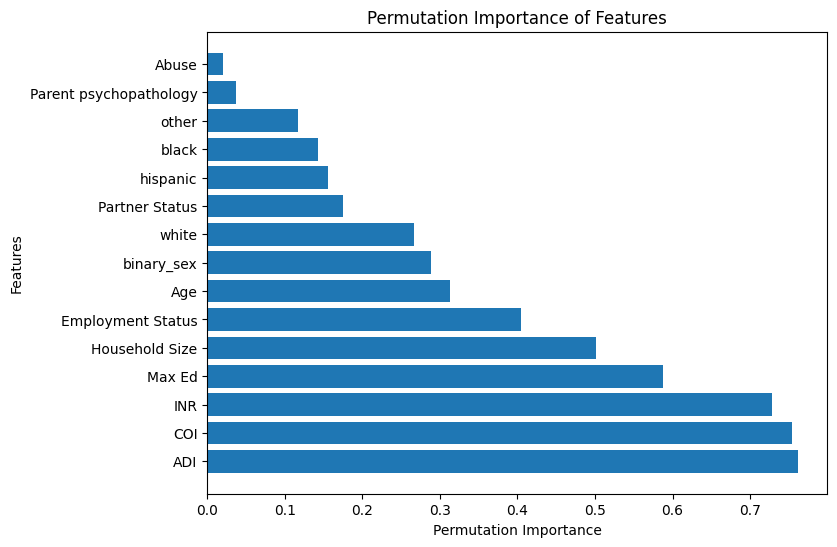

In [56]:
calculate_permutation_importance(pipe_e, X_1, y_e, 'f1')

### Supervisory Neglect

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

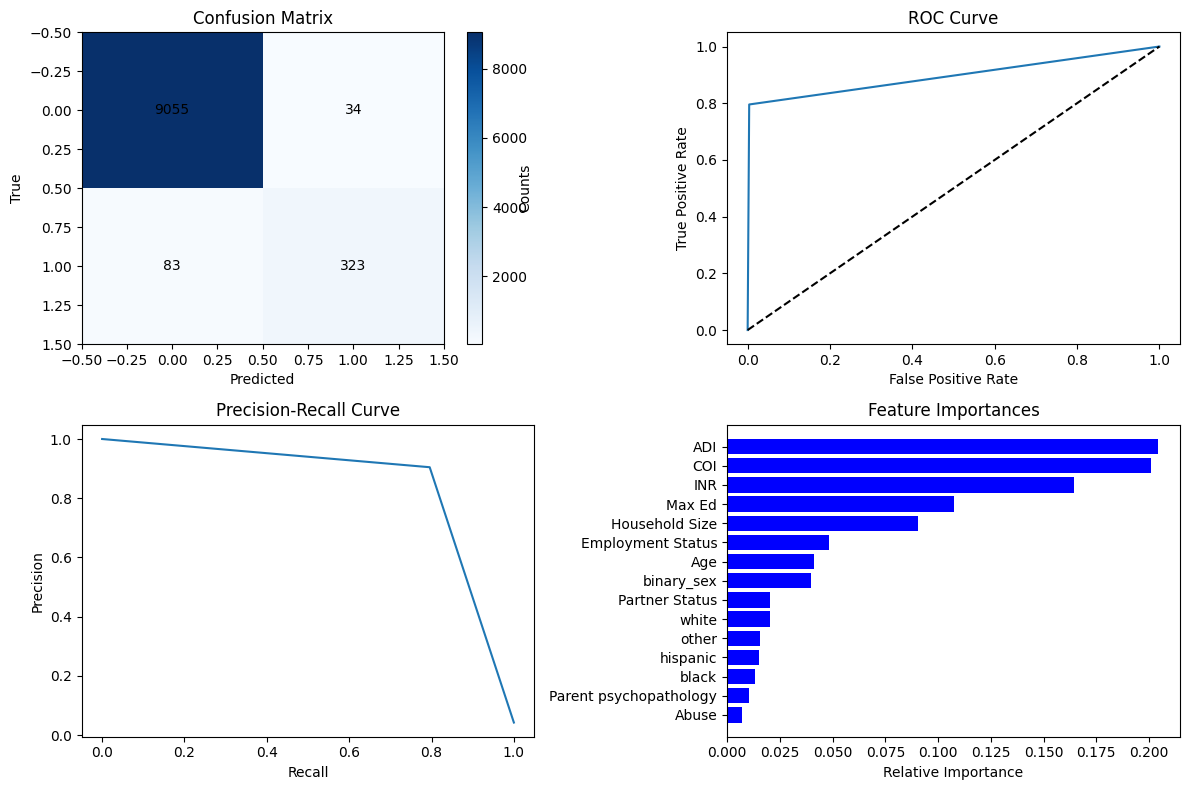

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.953660
1,Precision,0.916360
2,Recall,0.953660
3,F1,0.934638
4,Auc,0.498075


In [53]:
# Run single model
scores_s, pipe_s, model_s = run_single_model(X_1, y_s, strat_k_fold, scoring)

plot_evaluation(pipe_s, X_1, y_s)

generate_metrics_table(scores_s)

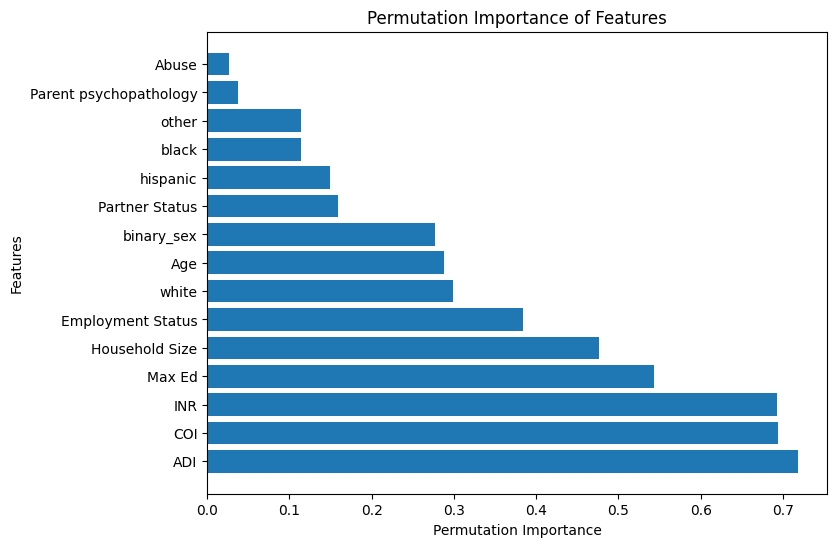

In [57]:
calculate_permutation_importance(pipe_s, X_1, y_s, 'f1')

# Interpretations

This contains Shapley analysis of the models and the predictor importances

## Shap function

In [ ]:
def interpret_model_predictions(model, X, class_index):
    # build a Tree explainer and explain the model predictions on the given dataset
    explainer = shap.Explainer(model)
    shap_values_raw = explainer.shap_values(X)

    # get just the explanations for the chosen class
    shap_values_raw_class = shap_values_raw[class_index]

    # create an Explanation object
    shap_values = shap.Explanation(values=shap_values_raw_class,
                                   data=X,
                                   feature_names=X.columns.to_list())

    # shap_interaction_values = explainer.shap_interaction_values(X)

    # bar
    shap.plots.bar(shap_values)

    # random
    shap.plots.bar(shap_values[0])

    # cohort plot

    # Create the cohort list
    cohorts = [determine_cohort(shap_values[i]) for i in range(shap_values.shape[0])]
    # Create the cohorts for your SHAP values
    cohort_shap_values = shap_values.cohorts(cohorts)

    # Compute the mean absolute SHAP values for each cohort
    mean_abs_shap_values = cohort_shap_values.abs.mean(0)

    # Plot the mean absolute SHAP values for each cohort
    shap.plots.bar(mean_abs_shap_values)

    # # auto cohort
    # shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

    # heatmap
    shap.plots.heatmap(shap_values)
    # waterfall
    # shap.plots.waterfall(shap_values[0])

    # interaction plot
    # shap.summary_plot(shap_interaction_values, X)
    # Get the mean absolute SHAP values for each feature
    # feature_importances = np.mean(np.abs(shap_values.values), axis=0)

    # # Get the feature names
    # feature_names = shap_values.feature_names

    # # Sort the features by importance
    # sorted_feature_indices = np.argsort(feature_importances)[::-1]

    # # Get the names of the top 4 features
    # top_features = [feature_names[i] for i in sorted_feature_indices[:4]]

    # # Create a dependence plot for each of the top 4 features
    # for feature in top_features:
    #     shap.dependence_plot(feature, shap_values.values, X)

In [ ]:
# Define your cohorts based on race/ethnicity.
def determine_cohort(instance_shap_values):
    if instance_shap_values["white"].data == 1:
        return "White"
    elif instance_shap_values["black"].data == 1:
        return "Black"
    elif instance_shap_values["hispanic"].data == 1:
        return "Hispanic"
    elif instance_shap_values["other"].data == 1:
        return "Other"
    else:
        return "Unknown"

## Physical neglect

In [ ]:
X_sample = X_1.sample(1000)

In [ ]:
X_subset = X_neg_2.sample(1000)

In [ ]:
X_new = X_neg_3.sample(1000)

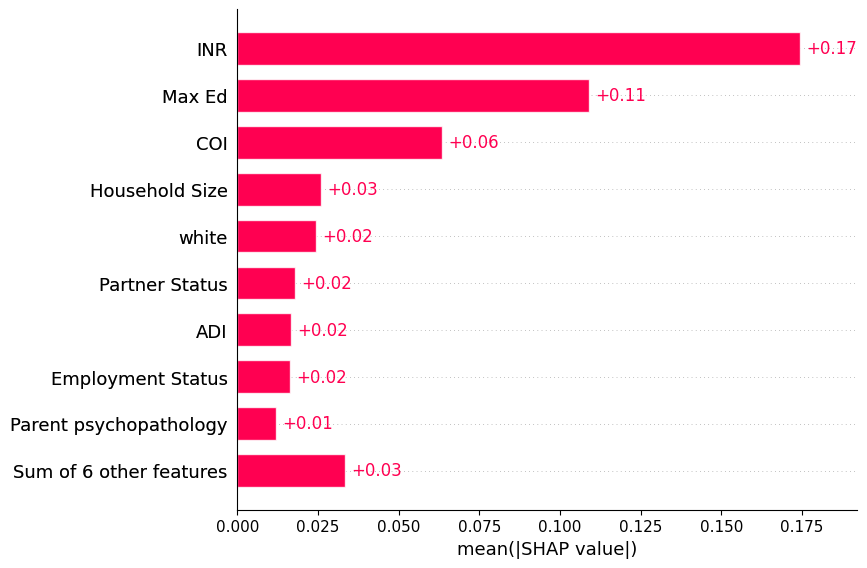

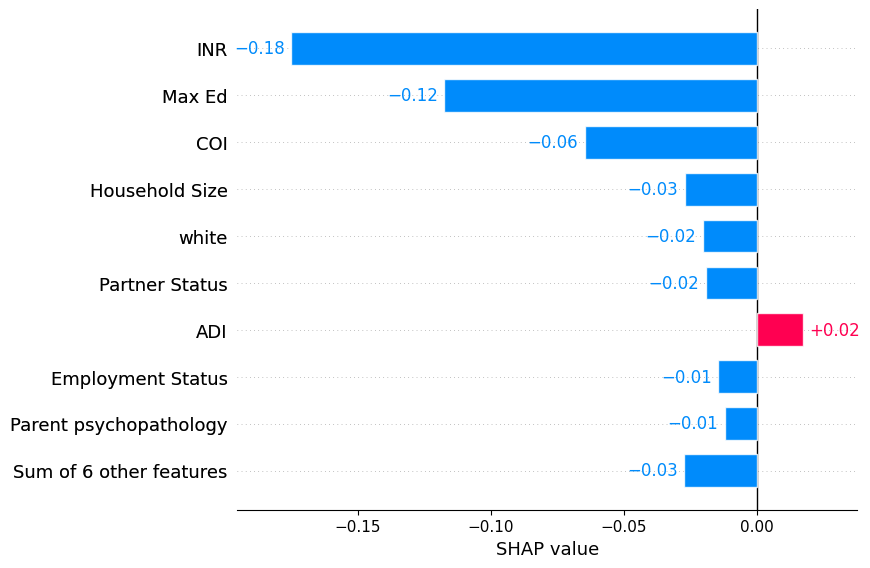

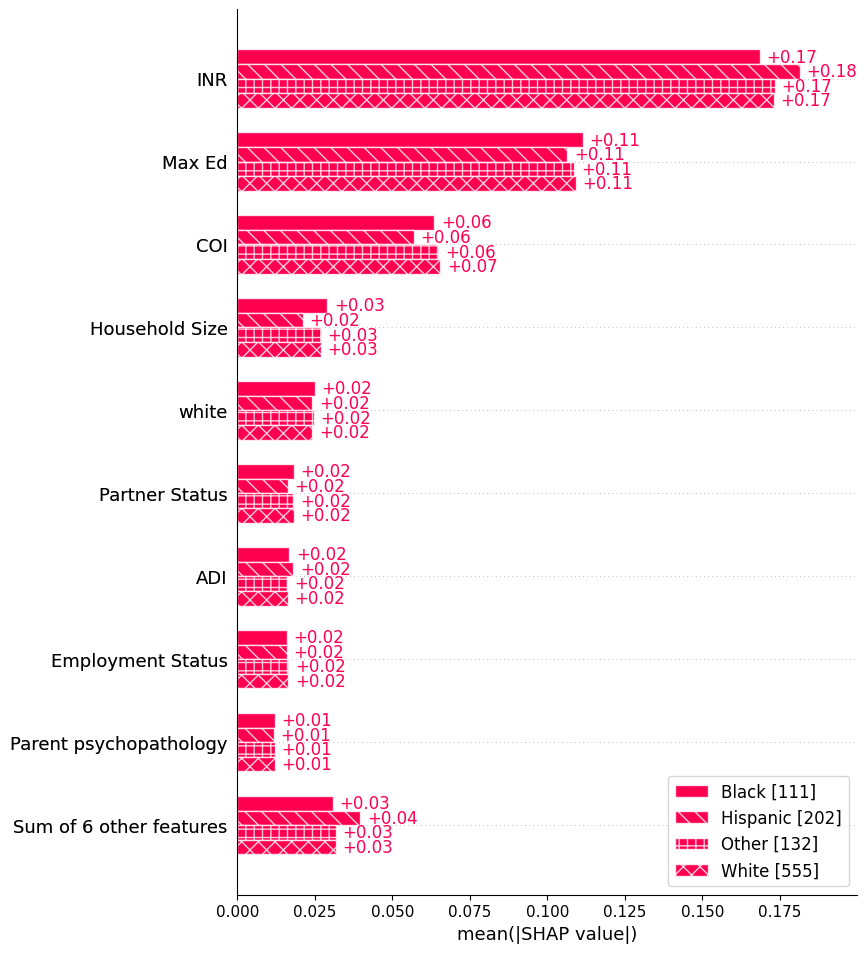

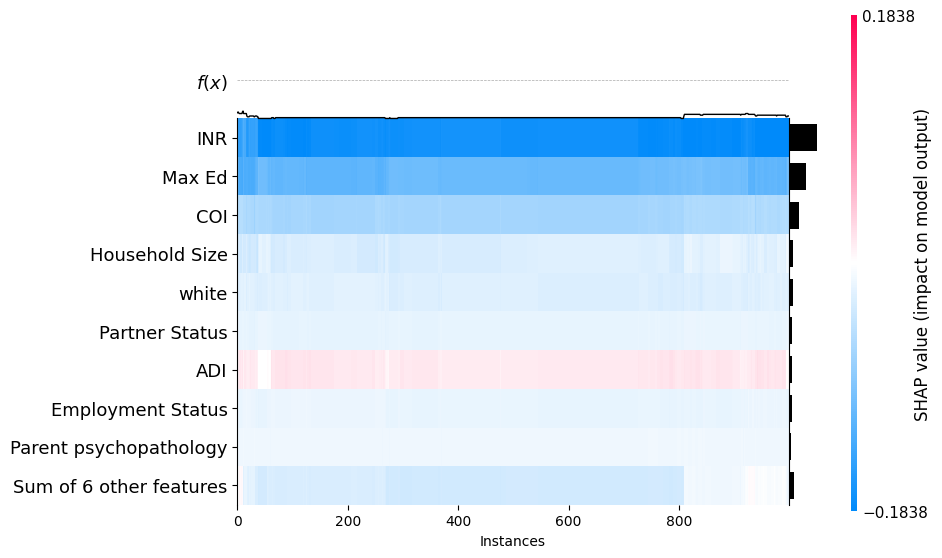

CPU times: user 1min 21s, sys: 1.59 s, total: 1min 23s
Wall time: 1min 20s


In [ ]:
%%time
interpret_model_predictions(model_p, X_sample, 1)

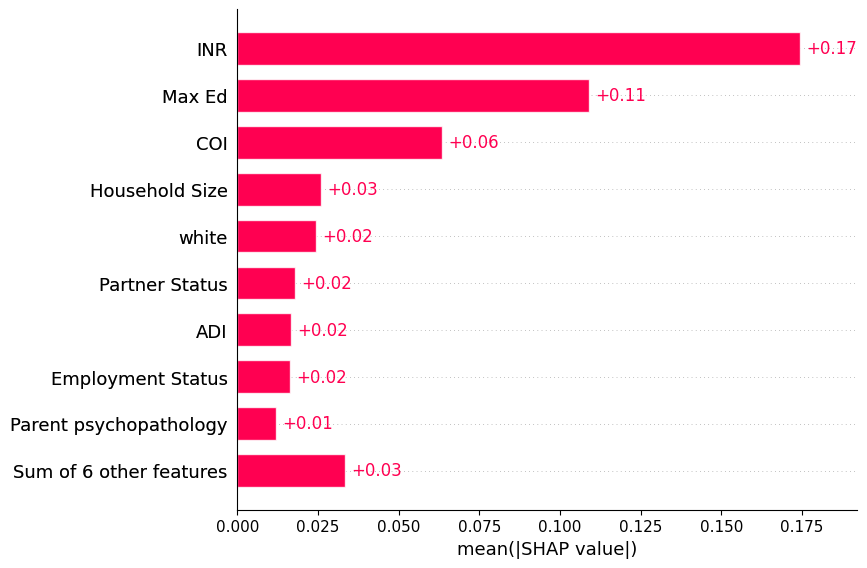

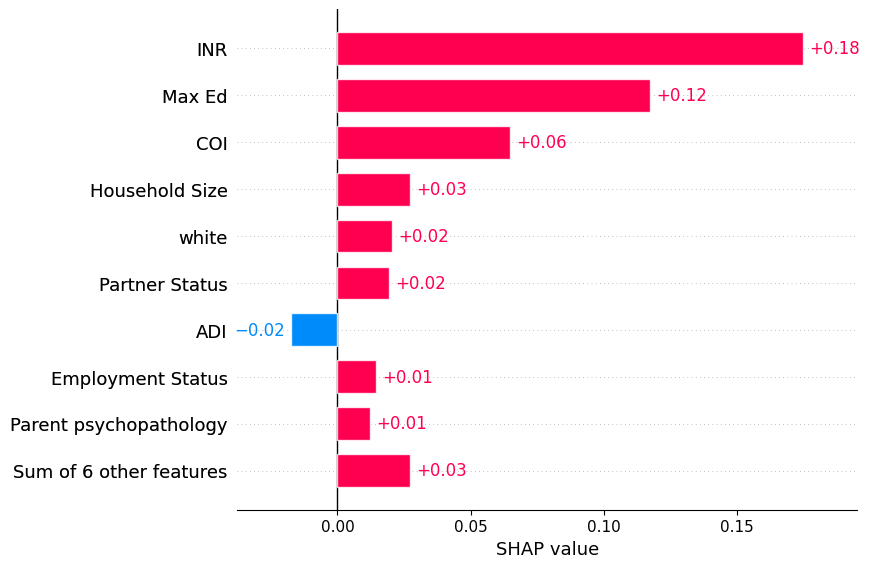

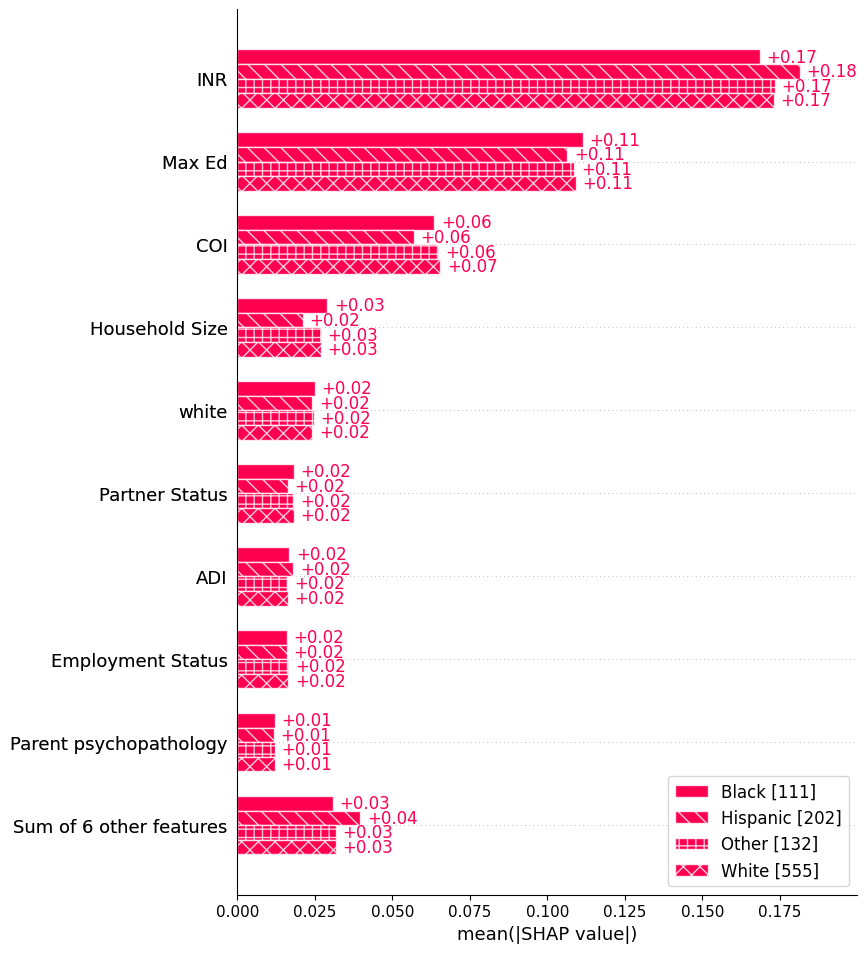

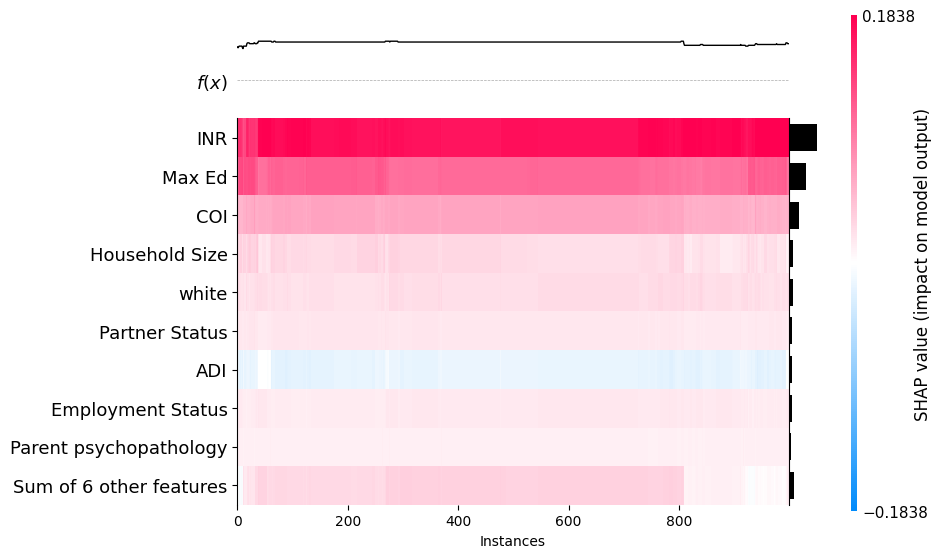

In [ ]:
interpret_model_predictions(model_p, X_sample, 0)

## Emotional neglect

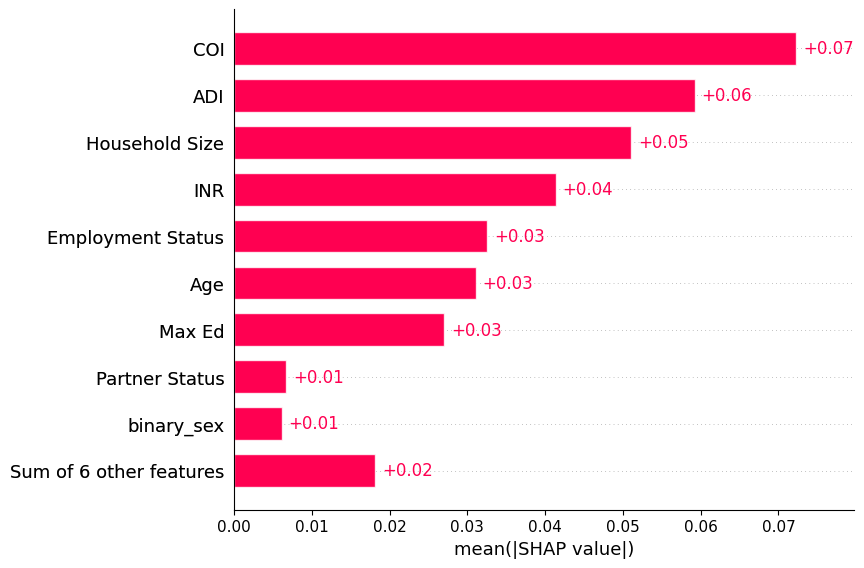

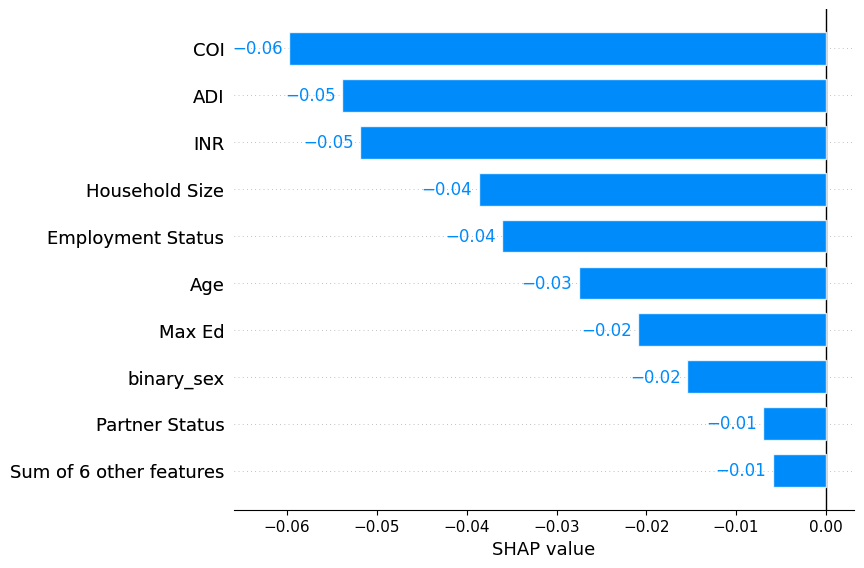

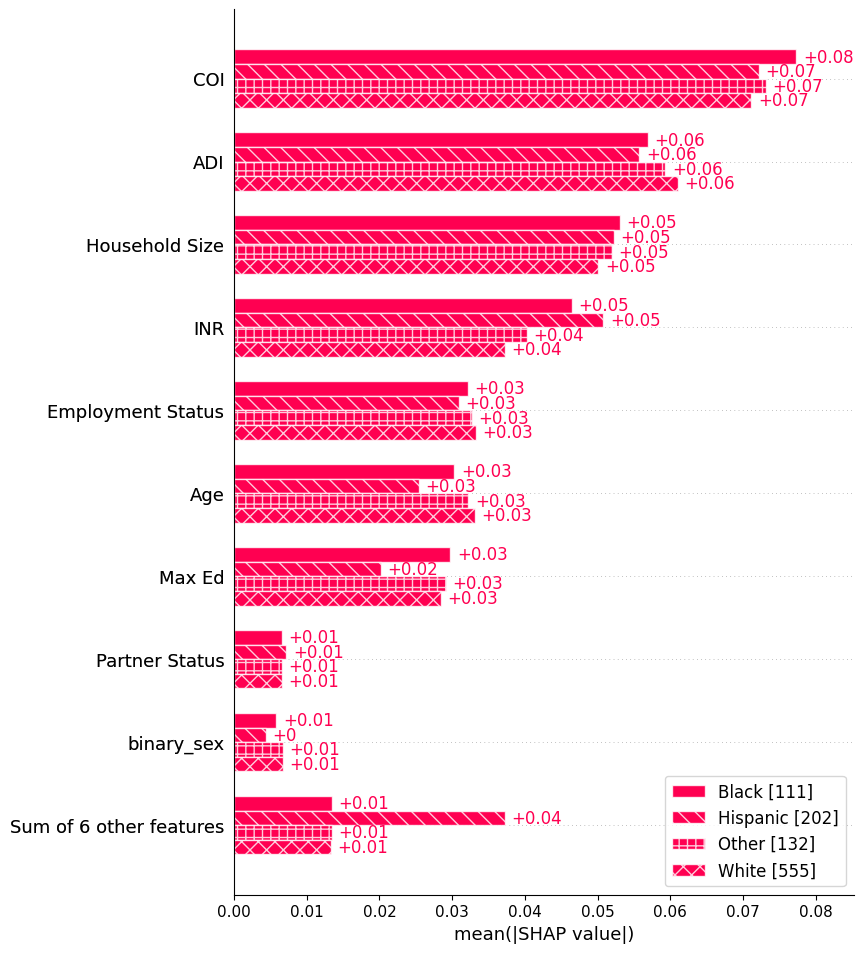

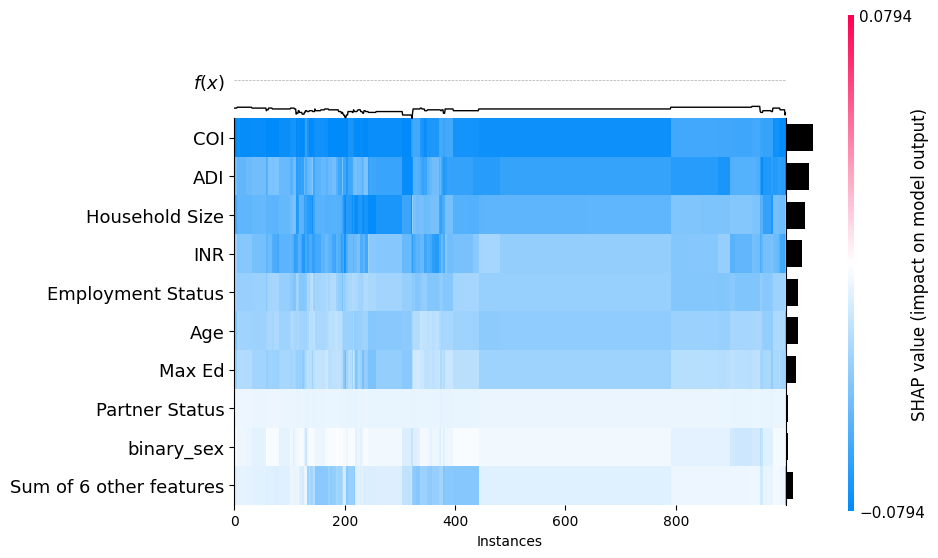

In [ ]:
interpret_model_predictions(model_e, X_sample, 1)

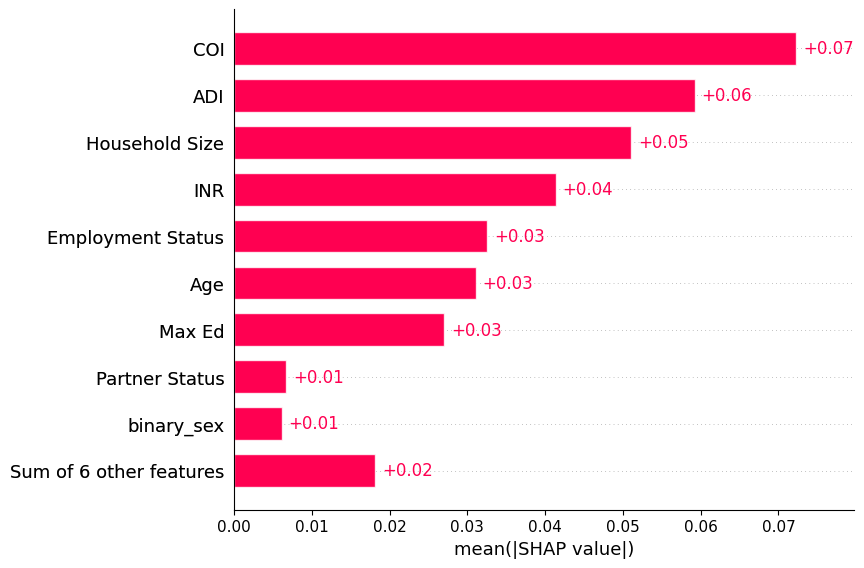

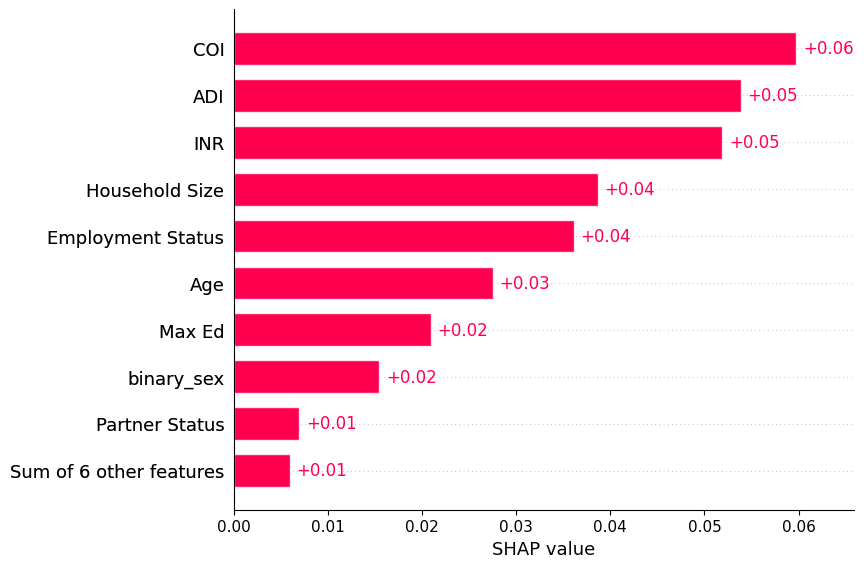

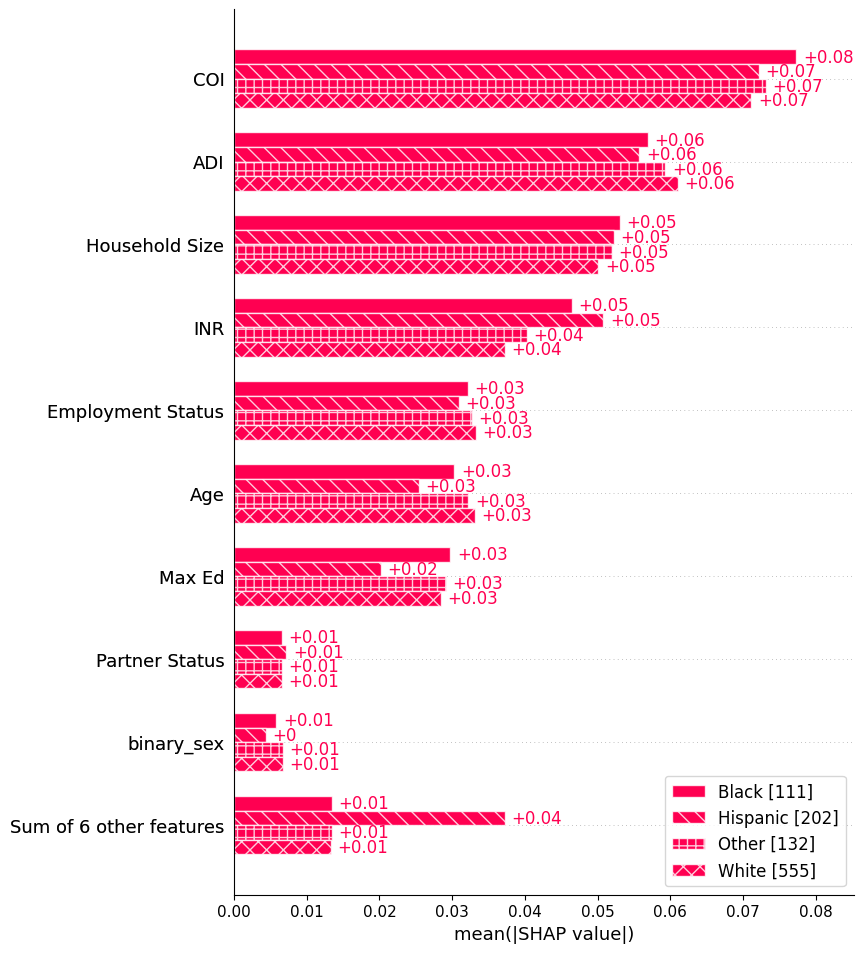

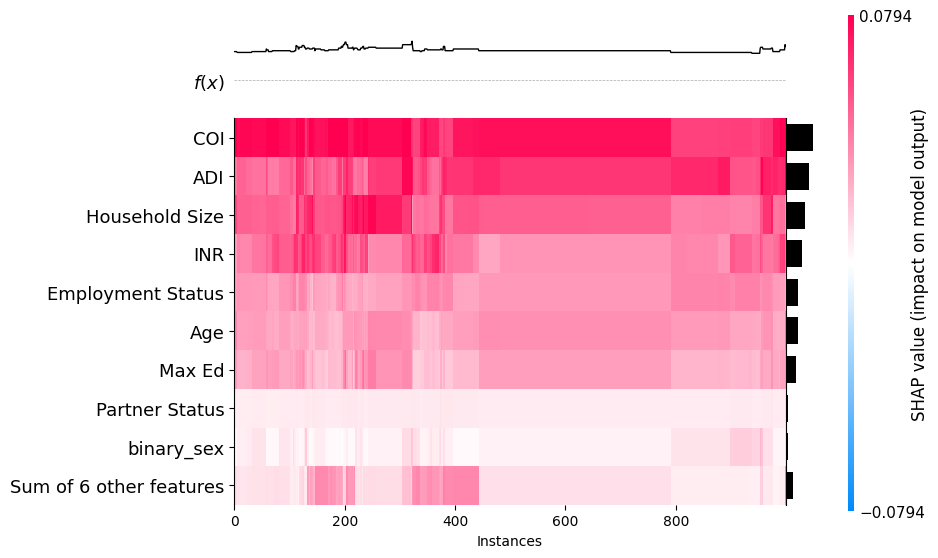

In [ ]:
interpret_model_predictions(model_e, X_sample, 0)

## Supervisory neglect

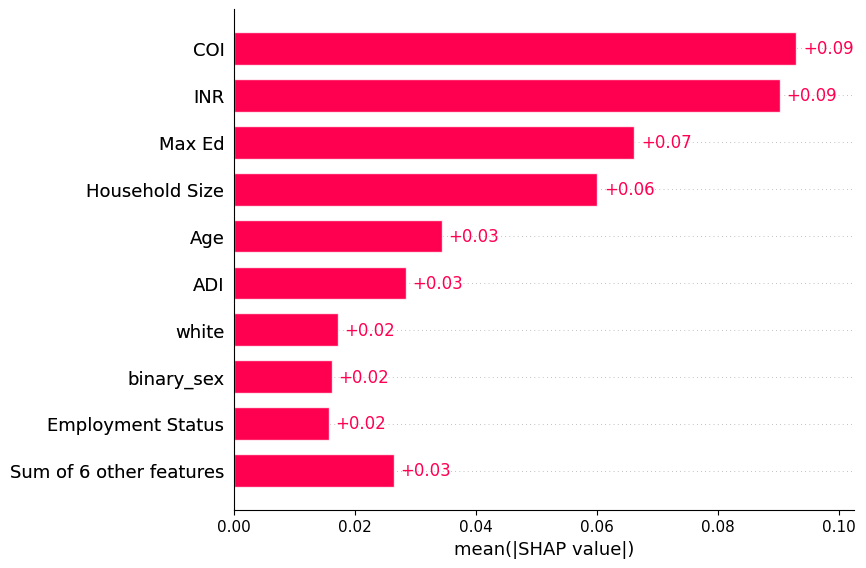

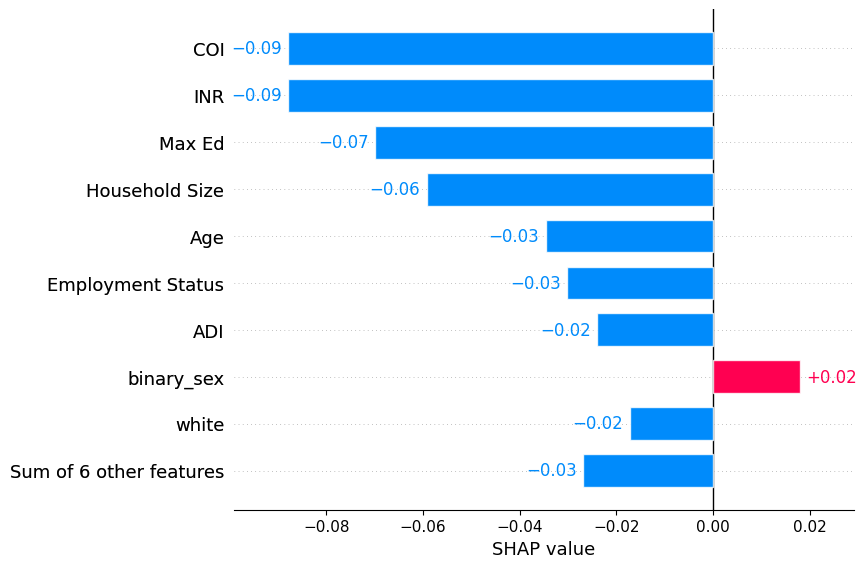

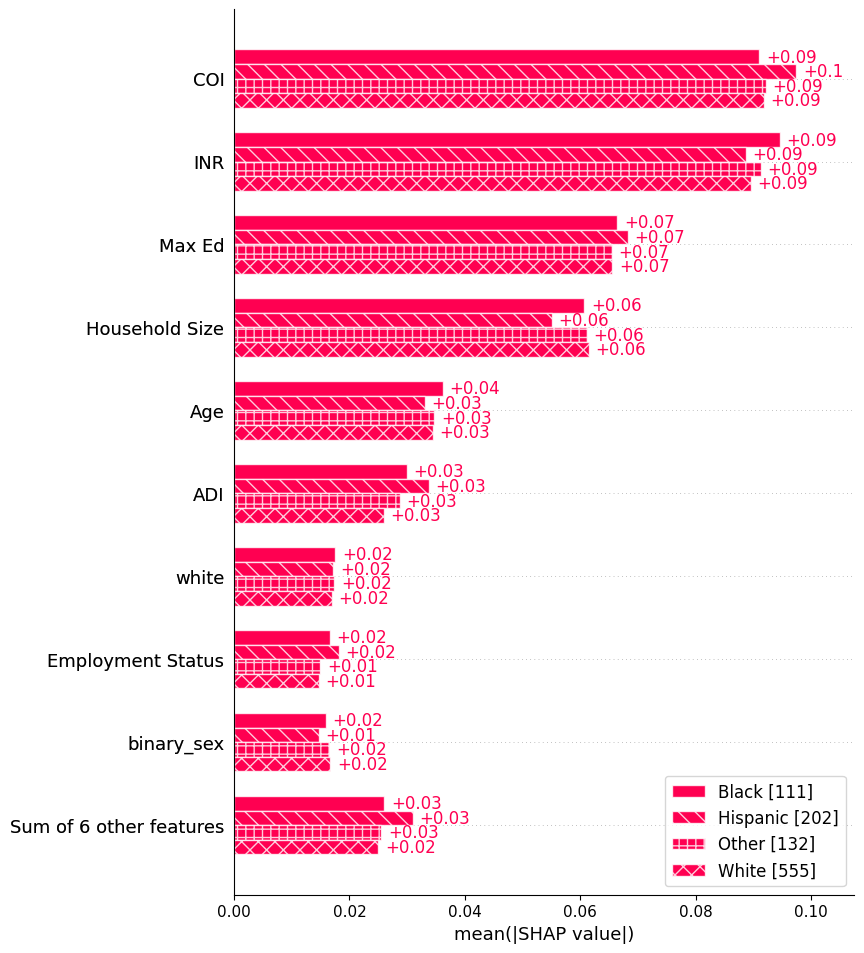

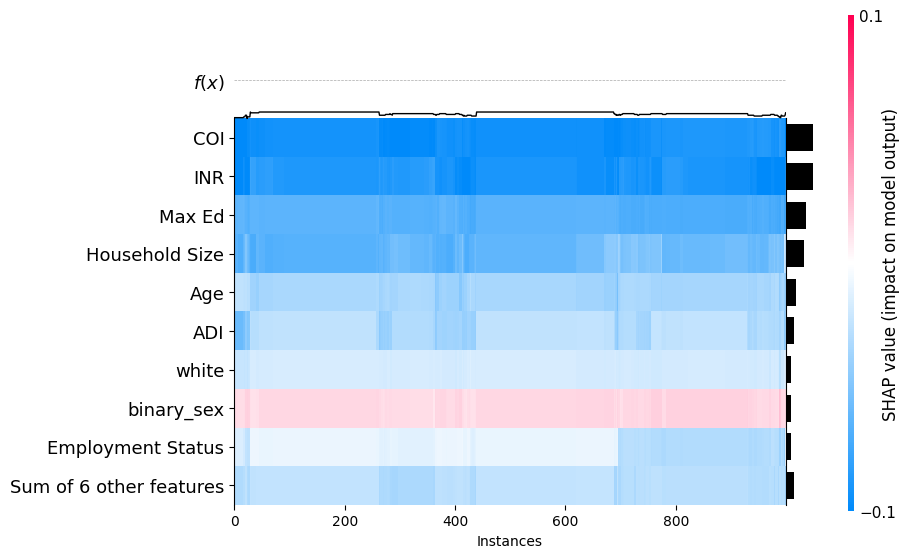

In [ ]:
interpret_model_predictions(model_s, X_sample, 1)

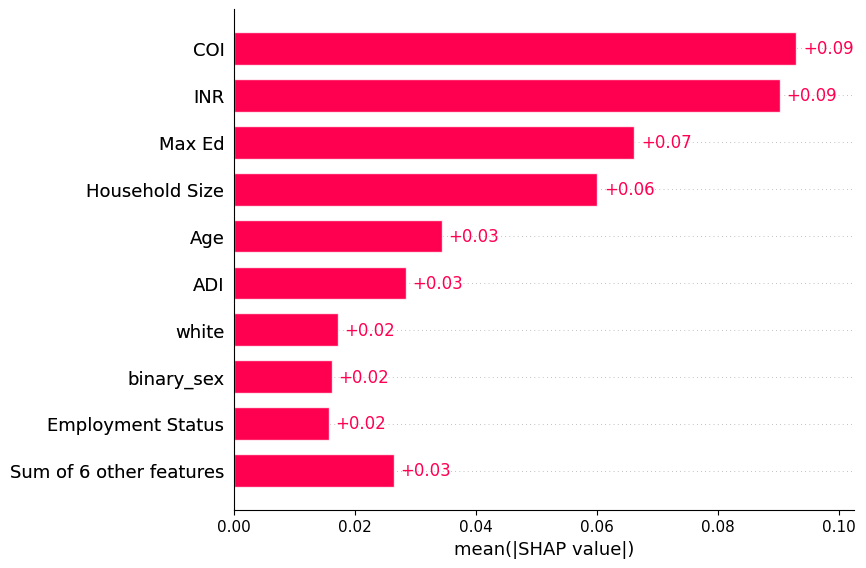

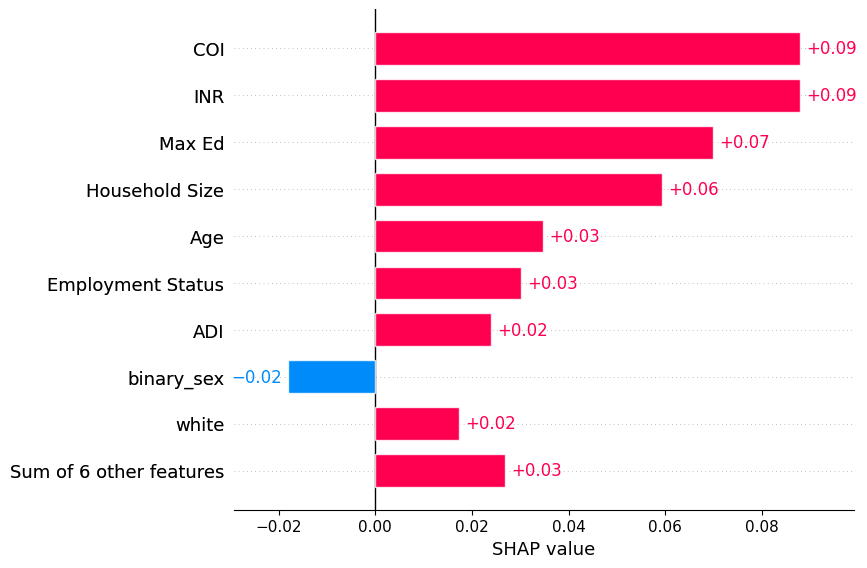

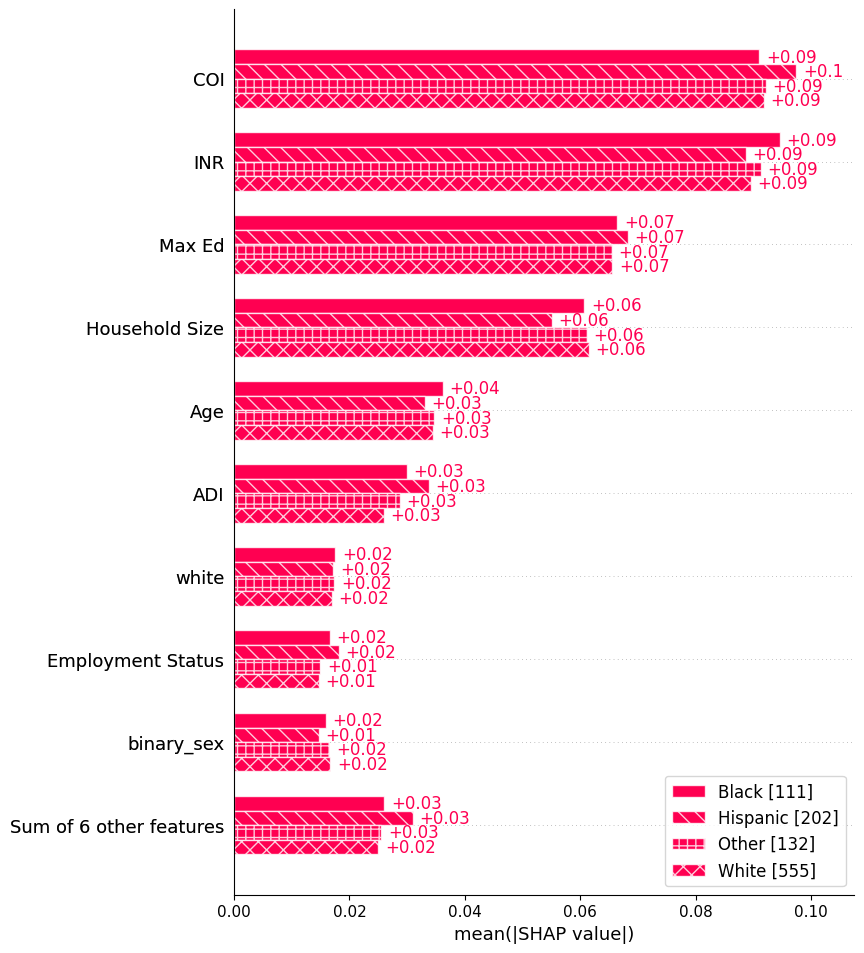

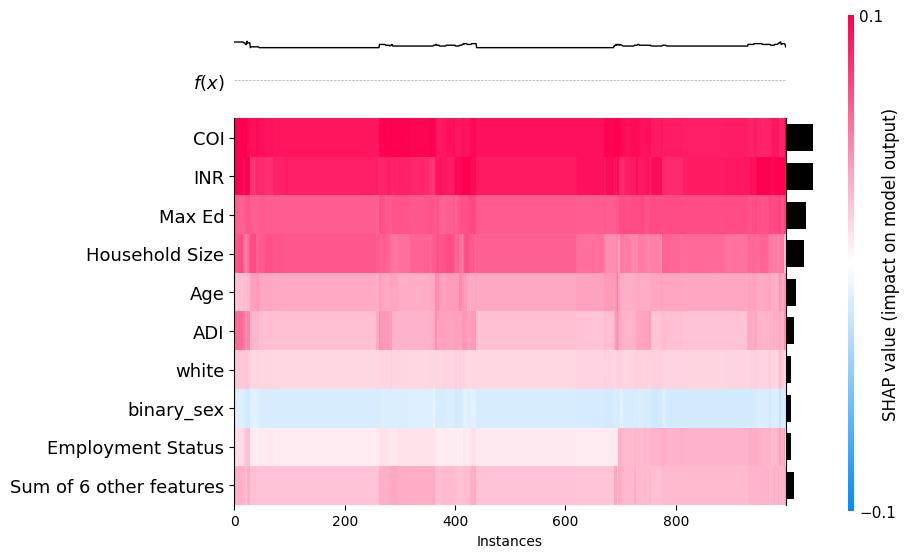

In [ ]:
interpret_model_predictions(model_s, X_sample, 0)